In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=5"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpyro
import numpyro.distributions as dist
import arviz as az

print(jax.devices())
jax.config.update("jax_enable_x64", True)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4)]


In [4]:
df = pd.read_csv("./data/NYC.csv")
x = df["Age"].to_numpy() / 1000
x_std = df["AgeError"].to_numpy() / 1000
y = df["RSL"].to_numpy()
y_std = df["RSLError"].to_numpy()
interval = 30 / 1000

x_grid = np.concatenate(
    [
        [(x - x_std).min()],
        np.arange(x.min(), x.max(), interval),
        [(x + x_std).max()],
    ]
)
x_star = x_grid - x.min()
x = x - x.min()

In [5]:
def powered_exponential(x, y, params):
    p, kappa, sigma = params["p"], params["kappa"], params["variance"]
    return sigma * (p ** (jnp.abs(x - y) ** kappa))


def evaluate_kernel(x, y, kernel_fn, params):
    K = jax.vmap(lambda x1: jax.vmap(lambda y1: kernel_fn(x1, y1, params))(y))(x)
    return K


@jax.jit
def integrate_kernel(x, x_star):
    # x is a vector of integral upper bounds
    kappa = 1.99
    integration_len = 30
    # [-1,1]
    chebyshev_nodes = jnp.cos(
        jnp.pi * (0.5 + jnp.arange(0, integration_len)) / integration_len
    )
    a = jnp.zeros_like(x)
    b = x

    # shape (len(x), 30)
    y = (
        ((b[:, None] - a[:, None]) / 2) * chebyshev_nodes[None, :]
        + ((b[:, None] - a[:, None]) / 2)
        + a[:, None]
    )
    # shape len(x), ngrid, 30
    quad1 = jnp.abs(y[:, None, :] - x_star[None, :, None]) ** kappa
    # print(y.shape)
    # print(quad1.shape)

    dy_coeff = (
        b[:, None, None] - a[:, None, None]
    ) / 2  # times dx (x is chebyshev nodes)
    chebyshev_func_form_coeff = jnp.sqrt(1 - chebyshev_nodes**2)
    weights = jnp.pi / integration_len

    quad2 = dy_coeff * weights * chebyshev_func_form_coeff[None, None, :]
    # print(quad2.shape)

    return quad1, quad2


print(x.shape)
print(x_star.shape)
quad1, quad2 = integrate_kernel(x, x_star)

(91,)
(50,)


In [6]:
def invert(matrix):
    """
    Inverts a positive-definite matrix using Cholesky decomposition.
    """
    # Perform Cholesky decomposition
    L = jax.scipy.linalg.cho_factor(matrix, lower=True)

    # Use Cholesky factors to compute the inverse
    identity = jnp.eye(matrix.shape[0])
    matrix_inv = jax.scipy.linalg.cho_solve(L, identity)

    return matrix_inv


# IGP model

use precomputed values for kernel integration based on just the observed x values.


In [7]:
def igp(x, y, x_std, y_std):
    # N = x.shape[0]
    alpha = numpyro.sample("beta0", dist.Normal(0, 1000.0))
    p = numpyro.sample("p", dist.Uniform(0.0, 1.0))
    # p = numpyro.deterministic("p", 0.005)
    kernel_precision = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))
    kernel_variance = 1 / kernel_precision
    microscale_std = numpyro.sample("sigma", dist.Uniform(0.01, 1.0))
    params = {"p": p, "kappa": 1.99, "variance": 1}

    # kernel computation and EIV sampling
    # x_true = numpyro.sample("x_true", dist.Normal(x, x_std).to_event(1))

    C_w = evaluate_kernel(x_star, x_star, powered_exponential, params)
    C_w += jnp.eye(len(x_star)) * 1e-5  # jitter
    # sample rates
    # Sample w_m (rates on grid) from its prior MVN(0, K_ww)
    w_m = numpyro.sample(
        "w_m", dist.MultivariateNormal(jnp.zeros(len(x_star)), C_w * kernel_variance)
    )

    Cw_inv_w_m = jnp.matmul(invert(C_w), w_m)

    # integral approximation
    # C_w is multiplied by variance, but in its inverse has the reciprocal of variance
    # set var as 1 and avoid variance mult
    K_hw = jnp.sum(p**quad1 * quad2, axis=2)  # * kernel_variance
    h_x = jnp.matmul(K_hw, Cw_inv_w_m)

    integrated_mean = numpyro.deterministic("int_mean", alpha + h_x)

    # h_integral_cond_exp = jnp.matmul(K_hw, K_ww_inv_w_m)
    with numpyro.plate("y_plate", len(y)):
        numpyro.sample(
            "y",
            dist.Normal(integrated_mean, jnp.sqrt(y_std**2 + microscale_std**2)),
            obs=y,
        )


mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        igp,
        dense_mass=True,
    ),
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
)
mcmc.run(jax.random.PRNGKey(1), x=x, y=y, x_std=x_std, y_std=y_std)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [06:56<00:00,  3.60it/s, 15 steps of size 3.12e-01. acc. prob=0.86]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -1.70      0.05     -1.70     -1.80     -1.61   1113.67      1.00
         p      0.02      0.04      0.01      0.00      0.06    211.26      1.00
     sigma      0.02      0.01      0.01      0.01      0.02    746.75      1.00
     tau_g      0.10      0.03      0.09      0.05      0.15    460.65      1.00
    w_m[0]      0.08      1.00      0.08     -1.54      1.80   1121.20      1.00
    w_m[1]      0.19      0.76      0.21     -1.01      1.55   1029.03      1.00
    w_m[2]      0.28      0.61      0.29     -0.70      1.30    972.74      1.00
    w_m[3]      0.36      0.47      0.36     -0.32      1.20    965.99      1.00
    w_m[4]      0.44      0.35      0.45     -0.14      1.02    993.04      1.00
    w_m[5]      0.51      0.28      0.52      0.11      1.01   1050.48      1.00
    w_m[6]      0.57      0.24      0.58      0.15      0.94   1327.61      1.00
    w_m[7]      0.62      0

In [8]:
# note that both are x_star here unlike before
quad1_pred, quad2_pred = integrate_kernel(x_star, x_star)
# can make all this cleaner by passing quads as params to mcmc func and getting posterior predictive
# with updated arguments


@jax.jit
def calculate_one_sample_pred_vmap(sample_params, sample_w_m):
    p_i = sample_params["p"]
    # var_i = sample_params["variance"]
    beta0_i = sample_params["beta0"]
    kappa = 1.99  # Or get from params if varied

    # Evaluate C_ww on original grid x_star
    kernel_params_i = {"p": p_i, "kappa": kappa, "variance": 1}
    C_ww_i = evaluate_kernel(x_star, x_star, powered_exponential, kernel_params_i)
    C_ww_i += jnp.eye(len(x_star)) * 1e-6  # Add jitter

    # Solve C_ww_inv @ w_m efficiently
    # L_ww_i, low_i = jax.scipy.linalg.cho_factor(C_ww_i, lower=True)
    # Cw_inv_w_m_i = jax.scipy.linalg.cho_solve((L_ww_i, low_i), sample_w_m)

    Cw_inv_w_m_i = jnp.matmul(invert(C_ww_i), sample_w_m)
    # Calculate K_hw using precomputed structure and current sample params
    # K_hw_orig_i = var_i * jnp.sum(
    #     p_i**quad1_pred * quad2_pred, axis=2
    # )  # Sum over L axis
    K_hw_orig_i = jnp.sum(p_i**quad1_pred * quad2_pred, axis=2)

    # Calculate h prediction on original grid
    h_pred_i = beta0_i + jnp.matmul(K_hw_orig_i, Cw_inv_w_m_i)

    # Rate prediction is just w_m
    w_pred_i = sample_w_m

    return h_pred_i, w_pred_i


samples = mcmc.get_samples()
if "kernel_variance" not in samples:
    samples["kernel_variance"] = 1.0 / samples["tau_g"]


sl_pred, rate_pred = jax.vmap(calculate_one_sample_pred_vmap)(
    {
        "p": samples["p"],
        "variance": samples["kernel_variance"],
        "beta0": samples["beta0"],
    },
    samples["w_m"],
)

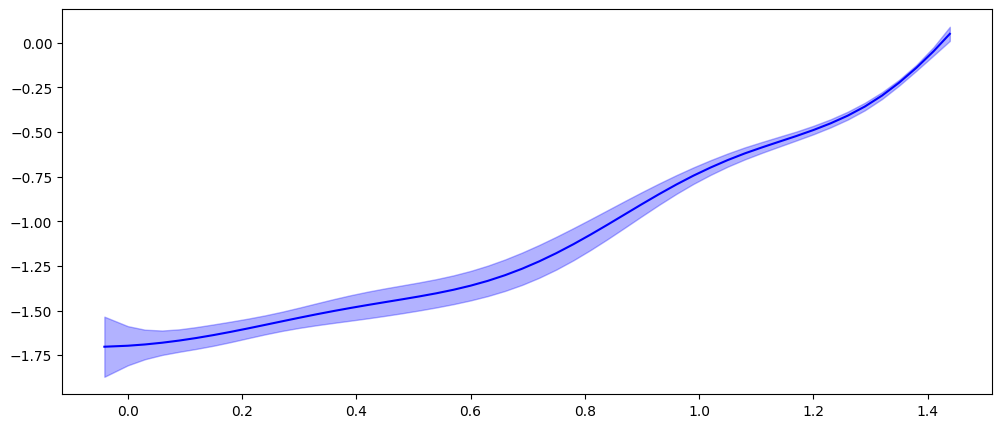

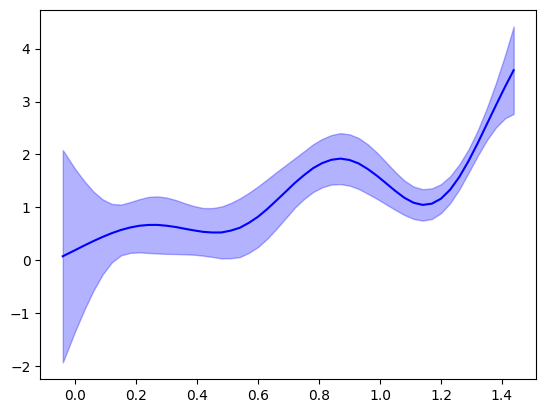

In [9]:
h_mean = np.mean(sl_pred, axis=0)
h_std = np.std(sl_pred, axis=0)
h_lower_ci = h_mean - 2 * h_std
h_upper_ci = h_mean + 2 * h_std

w_mean = np.mean(samples["w_m"], axis=0)
w_std = np.std(samples["w_m"], axis=0)
w_lower_ci = w_mean - 2 * w_std
w_upper_ci = w_mean + 2 * w_std


plt.figure(figsize=(12, 5))
plt.plot(x_star, h_mean, color="blue")
plt.fill_between(
    x_star,
    h_lower_ci,
    h_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()

plt.plot(x_star, w_mean, color="blue")
plt.fill_between(
    x_star,
    w_lower_ci,
    w_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()

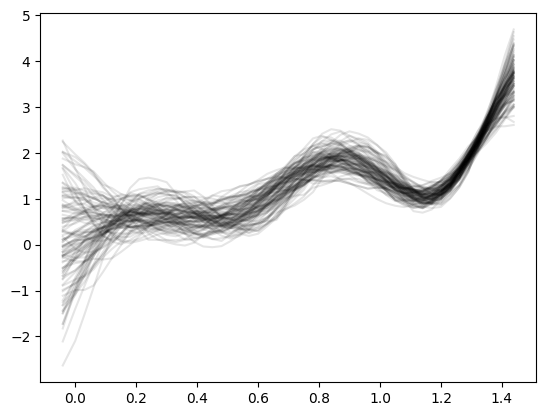

In [10]:
for i in range(100):
    plt.plot(x_star, samples["w_m"][i], c="black", alpha=0.1)

# EIV IGP


In [23]:
def eiv_igp(x, y, x_std, y_std):
    # N = x.shape[0]
    alpha = numpyro.sample("beta0", dist.Normal(0, 1000.0))
    p = numpyro.sample("p", dist.Uniform(0.0, 1.0))
    # p = numpyro.deterministic("p", 0.005)
    kernel_precision = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))
    kernel_variance = 1 / kernel_precision
    microscale_std = numpyro.sample("sigma", dist.Uniform(0.01, 1.0))
    params = {"p": p, "kappa": 1.99, "variance": 1}

    # kernel computation and EIV sampling
    x_true = numpyro.sample("x_true", dist.Normal(x, x_std).to_event(1))

    C_w = evaluate_kernel(x_star, x_star, powered_exponential, params)
    C_w += jnp.eye(len(x_star)) * 1e-5  # jitter
    # sample rates
    # Sample w_m (rates on grid) from its prior MVN(0, K_ww)
    w_m = numpyro.sample(
        "w_m", dist.MultivariateNormal(jnp.zeros(len(x_star)), C_w * kernel_variance)
    )

    Cw_inv_w_m = jnp.matmul(invert(C_w), w_m)

    # integral approximation
    # C_w is multiplied by variance, but in its inverse has the reciprocal of variance
    # set var as 1 and avoid variance mult
    quad1, quad2 = integrate_kernel(x_true, x_star)
    K_hw = jnp.sum(p**quad1 * quad2, axis=2)  # * kernel_variance
    h_x = jnp.matmul(K_hw, Cw_inv_w_m)

    # h_integral_cond_exp = jnp.matmul(K_hw, K_ww_inv_w_m)
    with numpyro.plate("obs_plate", len(y)):
        numpyro.sample(
            "x",
            dist.Normal(x_true, x_std),
            obs=x,
        )
        numpyro.sample(
            "y",
            dist.Normal(alpha + h_x, jnp.sqrt(y_std**2 + microscale_std**2)),
            obs=y,
        )


mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        eiv_igp,
        dense_mass=True,
    ),
    num_warmup=200,
    num_samples=800,
    num_chains=1,
    # progress_bar=False,
)
mcmc.run(jax.random.PRNGKey(1), x=x, y=y, x_std=x_std, y_std=y_std)
mcmc.print_summary()

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x10e40c040>
Traceback (most recent call last):
  File "/Users/rohan/miniconda3/envs/coral-analysis/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -1.71      0.06     -1.70     -1.81     -1.62    564.79      1.00
         p      0.05      0.12      0.02      0.00      0.10     62.79      1.00
     sigma      0.02      0.01      0.01      0.01      0.03    121.82      1.00
     tau_g      0.10      0.03      0.10      0.05      0.15    198.76      1.01
    w_m[0]      0.24      0.98      0.25     -1.26      1.82    296.55      1.01
    w_m[1]      0.32      0.74      0.34     -0.84      1.53    281.12      1.01
    w_m[2]      0.37      0.59      0.39     -0.66      1.24    281.95      1.01
    w_m[3]      0.43      0.45      0.43     -0.33      1.13    315.34      1.00
    w_m[4]      0.48      0.36      0.47     -0.12      1.01    414.78      1.00
    w_m[5]      0.53      0.29      0.52      0.01      0.95    632.06      1.00
    w_m[6]      0.56      0.26      0.56      0.11      0.96    666.83      1.00
    w_m[7]      0.59      0

In [12]:
# note that both are x_star here unlike before
quad1_pred, quad2_pred = integrate_kernel(x_star, x_star)
# can make all this cleaner by passing quads as params to mcmc func and getting posterior predictive
# with updated arguments


@jax.jit
def calculate_one_sample_pred_vmap(sample_params, sample_w_m):
    p_i = sample_params["p"]
    # var_i = sample_params["variance"]
    beta0_i = sample_params["beta0"]
    kappa = 1.99  # Or get from params if varied

    # Evaluate C_ww on original grid x_star
    kernel_params_i = {"p": p_i, "kappa": kappa, "variance": 1}
    C_ww_i = evaluate_kernel(x_star, x_star, powered_exponential, kernel_params_i)
    C_ww_i += jnp.eye(len(x_star)) * 1e-6  # Add jitter

    # Solve C_ww_inv @ w_m efficiently
    # L_ww_i, low_i = jax.scipy.linalg.cho_factor(C_ww_i, lower=True)
    # Cw_inv_w_m_i = jax.scipy.linalg.cho_solve((L_ww_i, low_i), sample_w_m)

    Cw_inv_w_m_i = jnp.matmul(invert(C_ww_i), sample_w_m)
    # Calculate K_hw using precomputed structure and current sample params
    # K_hw_orig_i = var_i * jnp.sum(
    #     p_i**quad1_pred * quad2_pred, axis=2
    # )  # Sum over L axis
    K_hw_orig_i = jnp.sum(p_i**quad1_pred * quad2_pred, axis=2)

    # Calculate h prediction on original grid
    h_pred_i = beta0_i + jnp.matmul(K_hw_orig_i, Cw_inv_w_m_i)

    # Rate prediction is just w_m
    w_pred_i = sample_w_m

    return h_pred_i, w_pred_i


samples = mcmc.get_samples()
if "kernel_variance" not in samples:
    samples["kernel_variance"] = 1.0 / samples["tau_g"]


sl_pred, rate_pred = jax.vmap(calculate_one_sample_pred_vmap)(
    {
        "p": samples["p"],
        "variance": samples["kernel_variance"],
        "beta0": samples["beta0"],
    },
    samples["w_m"],
)

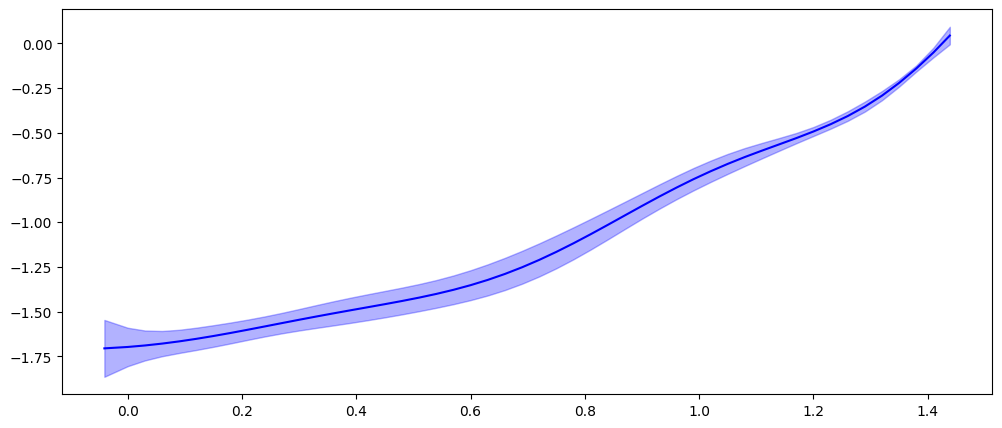

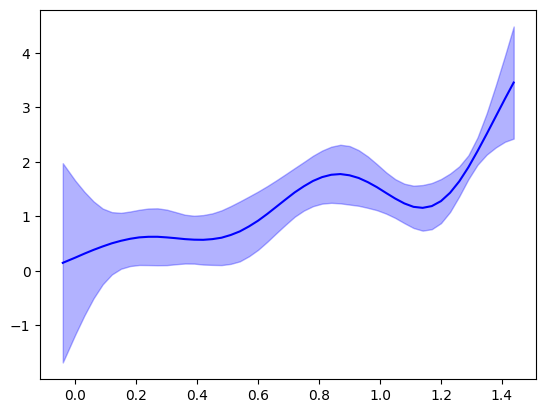

In [13]:
h_mean = np.mean(sl_pred, axis=0)
h_std = np.std(sl_pred, axis=0)
h_lower_ci = h_mean - 2 * h_std
h_upper_ci = h_mean + 2 * h_std

w_mean = np.mean(samples["w_m"], axis=0)
w_std = np.std(samples["w_m"], axis=0)
w_lower_ci = w_mean - 2 * w_std
w_upper_ci = w_mean + 2 * w_std


plt.figure(figsize=(12, 5))
plt.plot(x_star, h_mean, color="blue")
plt.fill_between(
    x_star,
    h_lower_ci,
    h_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()

plt.plot(x_star, w_mean, color="blue")
plt.fill_between(
    x_star,
    w_lower_ci,
    w_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()

In [21]:
from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import Adam


# Define the guide function
def guide(x, y, x_std, y_std):
    alpha_loc = numpyro.param("alpha_loc", 0.0)
    alpha_scale = numpyro.param(
        "alpha_scale", 1.0, constraint=dist.constraints.positive
    )
    numpyro.sample("beta0", dist.Normal(alpha_loc, alpha_scale))

    p_loc = numpyro.param("p_loc", 0.5)
    p_scale = numpyro.param("p_scale", 0.1, constraint=dist.constraints.positive)
    numpyro.sample("p", dist.Normal(p_loc, p_scale))

    tau_g_concentration = numpyro.param(
        "tau_g_concentration", 2.0, constraint=dist.constraints.positive
    )
    tau_g_rate = numpyro.param("tau_g_rate", 1.0, constraint=dist.constraints.positive)
    numpyro.sample("tau_g", dist.Gamma(tau_g_concentration, tau_g_rate))

    sigma_loc = numpyro.param("sigma_loc", 0.1, constraint=dist.constraints.positive)
    numpyro.sample("sigma", dist.Normal(sigma_loc, 0.01))


# Set up the optimizer and SVI
optimizer = Adam(1e-4)
svi = SVI(eiv_igp, guide, optimizer, loss=Trace_ELBO())

# Run SVI
num_steps = 5000
svi_result = svi.run(
    jax.random.PRNGKey(0), num_steps, x=x, y=y, x_std=x_std, y_std=y_std
)

# Extract the parameters
# params = svi_result.params
# print("Learned parameters:", params)

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/rohan/miniconda3/envs/coral-analysis/lib/python3.10/site-packages/jax/_src/linear_util.py:388: UserWarning: Found vars in model but not guide: {'x_true', 'w_m'}
  ans = _fun(*args, **kwargs)
100%|██████████| 5000/5000 [00:49<00:00, 100.24it/s, init loss: 164.1387, avg. loss [4751-5000]: 2786.9886]


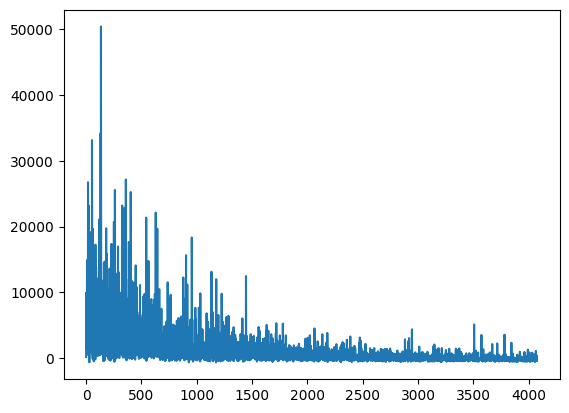

In [19]:
plt.plot(svi_result.losses)

{'alpha_loc': Array(nan, dtype=float64),
 'alpha_scale': Array(nan, dtype=float64),
 'p_loc': Array(nan, dtype=float64),
 'p_scale': Array(nan, dtype=float64),
 'sigma_loc': Array(nan, dtype=float64),
 'tau_g_concentration': Array(nan, dtype=float64),
 'tau_g_rate': Array(nan, dtype=float64)}

In [25]:
from src import igp

In [30]:
mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        igp.eiv_igp,
        dense_mass=True,
    ),
    num_warmup=200,
    num_samples=500,
    num_chains=1,
)
mcmc.run(
    jax.random.PRNGKey(1),
    x=x,
    y=y,
    x_std=x_std,
    y_std=y_std,
    x_star=x_star,
    simplify=True,
)
mcmc.print_summary()

sample: 100%|██████████| 700/700 [08:03<00:00,  1.45it/s, 31 steps of size 2.18e-01. acc. prob=0.93]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -1.70      0.06     -1.69     -1.78     -1.59    592.19      1.00
         p      0.02      0.02      0.01      0.00      0.05    235.03      1.00
     sigma      0.02      0.00      0.01      0.01      0.02    505.88      1.00
     tau_g      0.10      0.03      0.10      0.05      0.15    139.79      1.01
    w_m[0]      0.04      1.04      0.06     -1.69      1.74    554.34      1.00
    w_m[1]      0.15      0.80      0.16     -1.06      1.54    471.50      1.00
    w_m[2]      0.25      0.63      0.27     -0.78      1.27    433.36      1.00
    w_m[3]      0.34      0.49      0.35     -0.45      1.15    416.60      1.00
    w_m[4]      0.42      0.38      0.43     -0.26      0.98    453.59      1.00
    w_m[5]      0.50      0.29      0.51      0.04      1.00    582.57      1.00
    w_m[6]      0.57      0.25      0.58      0.13      0.95    605.16      1.00
    w_m[7]      0.62      0

In [31]:
@jax.jit
def calculate_one_sample_pred_vmap(sample_params, sample_w_m):
    p_i = sample_params["p"]
    var_i = sample_params["variance"]
    beta0_i = sample_params["beta0"]
    kappa = 1.99  # Or get from params if varied

    # Evaluate C_ww on original grid x_star
    kernel_params_i = {"p": p_i, "kappa": kappa, "variance": var_i}
    C_ww_i = igp.evaluate_kernel(x_star[:, None], x_star[None, :], kernel_params_i)
    C_ww_i += jnp.eye(len(x_star)) * 1e-6  # Add jitter

    # Solve C_ww_inv @ w_m efficiently
    # L_ww_i, low_i = jax.scipy.linalg.cho_factor(C_ww_i, lower=True)
    # Cw_inv_w_m_i = jax.scipy.linalg.cho_solve((L_ww_i, low_i), sample_w_m)

    Cw_inv_w_m_i = jnp.matmul(igp.invert(C_ww_i), sample_w_m)
    # Calculate K_hw using precomputed structure and current sample params
    # K_hw_orig_i = var_i * jnp.sum(
    #     p_i**quad1_pred * quad2_pred, axis=2
    # )  # Sum over L axis
    K_hw_orig_i = igp.integrate_kernel(x_star, x_star, kernel_params_i)

    # Calculate h prediction on original grid
    h_pred_i = beta0_i + jnp.matmul(K_hw_orig_i, Cw_inv_w_m_i)

    # Rate prediction is just w_m
    w_pred_i = sample_w_m

    return h_pred_i, w_pred_i


samples = mcmc.get_samples()
if "kernel_variance" not in samples:
    samples["kernel_variance"] = 1.0 / samples["tau_g"]


sl_pred, rate_pred = jax.vmap(calculate_one_sample_pred_vmap)(
    {
        "p": samples["p"],
        "variance": samples["kernel_variance"],
        "beta0": samples["beta0"],
    },
    samples["w_m"],
)

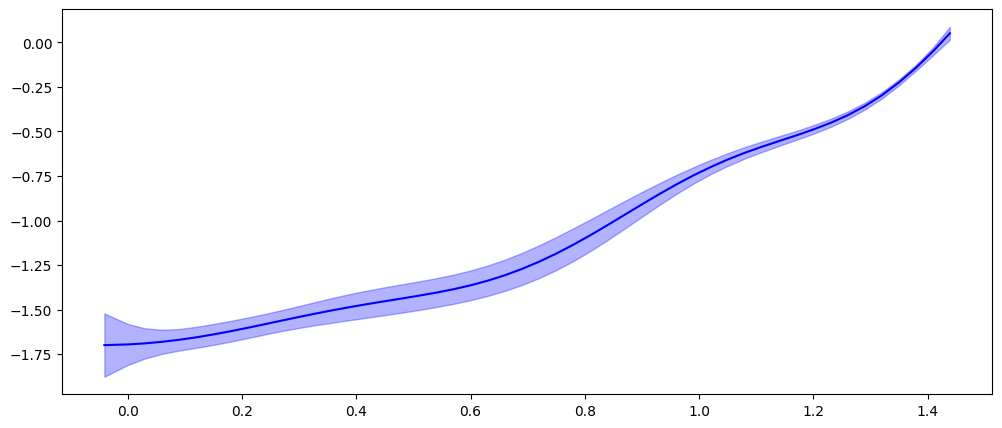

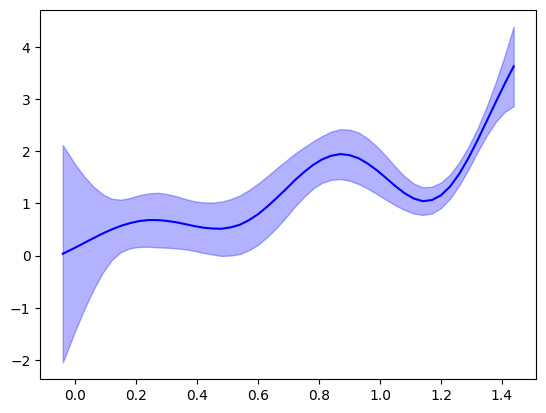

In [32]:
h_mean = np.mean(sl_pred, axis=0)
h_std = np.std(sl_pred, axis=0)
h_lower_ci = h_mean - 2 * h_std
h_upper_ci = h_mean + 2 * h_std

w_mean = np.mean(samples["w_m"], axis=0)
w_std = np.std(samples["w_m"], axis=0)
w_lower_ci = w_mean - 2 * w_std
w_upper_ci = w_mean + 2 * w_std


plt.figure(figsize=(12, 5))
plt.plot(x_star, h_mean, color="blue")
plt.fill_between(
    x_star,
    h_lower_ci,
    h_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()

plt.plot(x_star, w_mean, color="blue")
plt.fill_between(
    x_star,
    w_lower_ci,
    w_upper_ci,
    color="blue",
    alpha=0.3,
)
plt.show()